<a href="https://colab.research.google.com/github/Sixie0513/2020Hackathon_Kronos/blob/main/krono.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install logbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.7 MB/s 
  Created wheel for logbook: filename=Logbook-1.5.3-cp37-cp37m-linux_x86_64.whl size=66399 sha256=0a50494e12abe8dfcbf5ccfdb14415d6786fa2e0b330980d37ac463f4650794b
  Stored in directory: /root/.cache/pip/wheels/95/4b/a3/fc9b9d17a06a956767a8dc74058ba64d4306653df2289094cc
Successfully built logbook


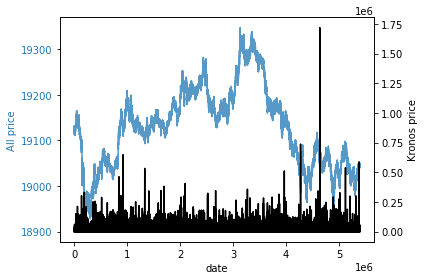

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                 ID     price     size  size_in_quote  \
0        1994679580  19123.35  0.00116      22.183086   
1        1994679581  19123.36  0.00404     -77.258374   
2        1994679582  19123.35  0.00078      14.916213   
3        1994679583  19123.36  0.00067     -12.812651   
4        1994679584  19123.35  0.00183      34.995731   
...             ...       ...      ...            ...   
5391085  2000070665  19043.07  0.00130     -24.755991   
5391086  2000070666  19041.97  0.00150      28.562955   
5391087  2000070667  19041.97  0.00117      22.279105   
5391088  2000070668  19041.97  0.00116      22.088685   
5391089  2000070669  19041.92  0.00267      50.841926   

         trade_time_in_millisecond  is_the_buyer_market_maker  ignore  p_n  
0                    1666224000000                       True    True  1.0  
1                    1666224000003                      False    True -1.0  
2                    1666224000005                       True    True  1.0  
3      

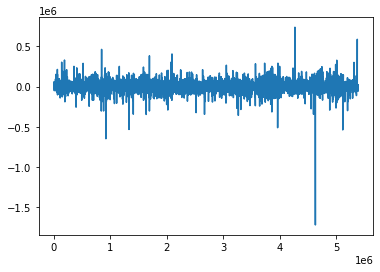

In [ ]:
from ctypes import sizeof
from datetime import datetime
import requests
import shutil
from dateutil.relativedelta import relativedelta
import pandas as pd
from logbook import Logger
import logbook
from zipfile import ZipFile
import time
import os
import matplotlib.pyplot as plt

log = Logger('binance_data.py', level=logbook.INFO)

columns = ['ID', 'price', 'size', 'size_in_quote', 'trade_time_in_millisecond', 'is_the_buyer_market_maker', 'ignore', 'p_n']

def download_spot_klines(symbol, way, date: datetime, path):
    url = 'https://data.binance.vision/data/spot/daily/%s/%s/%s-%s-%s-%02d-%02d.zip' % (way, symbol, symbol, way, date.year, date.month, date.day)
    log.info(url)

    with requests.get(url, stream=True) as r:
        with open(path, 'wb') as f:
            shutil.copyfileobj(r.raw, f)

    return path


def download_spot_klines_range(symbol, way, start: datetime, end: datetime, dir=''):
    floa = {}
    abs_floa = {}
    res = {}
    if len(dir) > 0 and not dir.endswith('/'):
        dir += '/'
    os.makedirs('%s%s/%s' % (dir, way, symbol), exist_ok=True)

    while True:

        path = '%s%s/%s/%s-%s-%s-%02d-%02d.zip' % (dir, way, symbol, symbol, way, start.year, start.month, start.day)
        csv_file = '%s-%s-%s-%02d-%02d.csv' % (symbol, way, start.year, start.month, start.day)

        download_spot_klines(symbol, way, start, path)

        zf = ZipFile(path)
        file = zf.open(csv_file)
        df = pd.read_csv(file, header=None, names=columns)

        # 1-analysis
        fig, ax1 = plt.subplots()
        plt.xlabel('date')
        ax2 = ax1.twinx()

        ax1.set_ylabel('All price', color = 'tab:blue')
        ax1.plot(range(len(df.price)), df.price, color = 'tab:blue', alpha = 0.75)
        ax1.tick_params(axis = 'y', labelcolor = 'tab:blue')

        ax2.set_ylabel('Kronos price', color = 'black')
        ax2.plot(range(len(df.size_in_quote)), df.size_in_quote, color = 'black', alpha = 1)
        ax2.tick_params(axis = 'y', labelcolor = 'black')

        fig.tight_layout()
        plt.show()

        # 2-analysis
        i = 0
        for i in range(min(df.index), max(df.index)):
          if (df.is_the_buyer_market_maker[i] == False):
            df.size_in_quote[i] *= -1
        df.size_in_quote.plot()
 

        # modeling
        i = min(df.index)
        while (i < min(df.index) + 11000):
          if (df.is_the_buyer_market_maker[i] == False):
            df.p_n[i] = -1
          elif (df.is_the_buyer_market_maker[i] == True):
            df.p_n[i] = 1
          i += 1
        print(df)

        i = min(df.index)
        while (i < min(df.index) + 10000):
          abs_floa[i] = abs((df.size_in_quote[i + 10] * df.p_n[i + 10] - df.size_in_quote[i] * df.p_n[i]) / (df.size_in_quote[i] * df.p_n[i]))
          floa[i] = (df.size_in_quote[i + 10] * df.p_n[i + 10] - df.size_in_quote[i] * df.p_n[i]) / (df.size_in_quote[i] * df.p_n[i])
          i += 10
        
        abs_floa1 = sorted(abs_floa.items(), key = lambda kv:(kv[1], kv[0]), reverse = True)
        j = 0
        for i in abs_floa1:
          if (j < 0.05*len(abs_floa1)):
            res[i[0]] = (df.price[i[0]+20] - df.price[i[0]+10]) / df.price[i[0]+10]
            j += 1
        
        j = 0
        k = 0
        for i in res.keys():
          # 賣出
          k += 1
          if (floa[i] == abs_floa[i]):
            if (res[i] < 0):
              j -= 1
            else:
              j += 1
          else:
            if (res[i] < 0):
              j += 1
            else:
              j -= 1
        
        print(j/k)


        file.close()
        zf.close()

        start = start + relativedelta(days=+1)
        if start > end:
            break

        time.sleep(2)

if __name__ == '__main__':
    download_spot_klines_range('BTCUSDT', 'trades', start=datetime(2022, 10, 20), end=datetime(2022, 10, 20))

In [4]:
from ctypes import sizeof
from datetime import datetime
import requests
import shutil
from dateutil.relativedelta import relativedelta
import pandas as pd
from logbook import Logger
import logbook
from zipfile import ZipFile
import time
import os
import matplotlib.pyplot as plt
import numpy as np

log = Logger('binance_data.py', level=logbook.INFO)

columns = ['ID', 'price', 'size', 'size_in_quote', 'trade_time_in_millisecond', 'is_the_buyer_market_maker', 'ignore', 'p_n']

def download_spot_klines(symbol, way, date: datetime, path):
    url = 'https://data.binance.vision/data/spot/daily/%s/%s/%s-%s-%s-%02d-%02d.zip' % (way, symbol, symbol, way, date.year, date.month, date.day)
    log.info(url)

    with requests.get(url, stream=True) as r:
        with open(path, 'wb') as f:
            shutil.copyfileobj(r.raw, f)

    return path


def download_spot_klines_range(symbol, way, start: datetime, end: datetime, dir=''):
    floa = {}
    abs_floa = {}
    res = {}
    if len(dir) > 0 and not dir.endswith('/'):
        dir += '/'

    os.makedirs('%s%s/%s' % (dir, way, symbol), exist_ok=True)

    while True:

        path = '%s%s/%s/%s-%s-%s-%02d-%02d.zip' % (dir, way, symbol, symbol, way, start.year, start.month, start.day)
        csv_file = '%s-%s-%s-%02d-%02d.csv' % (symbol, way, start.year, start.month, start.day)

        download_spot_klines(symbol, way, start, path)

        zf = ZipFile(path)
        file = zf.open(csv_file)
        df = pd.read_csv(file, header=None, names=columns)

        i = min(df.index)
        while (i < min(df.index) + 1100):
          if (df.is_the_buyer_market_maker[i] == False):
            df.p_n[i] = -1
          elif (df.is_the_buyer_market_maker[i] == True):
            df.p_n[i] = 1
          i += 1
        print(df)

        i = min(df.index)
        while (i < min(df.index) + 1000):
          abs_floa[i] = abs((df.size_in_quote[i + 10] * df.p_n[i + 10] - df.size_in_quote[i] * df.p_n[i]) / (df.size_in_quote[i] * df.p_n[i]))
          floa[i] = (df.size_in_quote[i + 10] * df.p_n[i + 10] - df.size_in_quote[i] * df.p_n[i]) / (df.size_in_quote[i] * df.p_n[i])
          i += 10
        
        abs_floa1 = sorted(abs_floa.items(), key = lambda kv:(kv[1], kv[0]), reverse = True)
        j = 0
        for i in abs_floa1:
          if (j < 0.05*len(abs_floa1)):
            res[i[0]] = (df.price[i[0]+20] - df.price[i[0]+10]) / df.price[i[0]+10]
            j += 1
        
        j = 0
        k = 0
        for i in res.keys():
          # 賣出
          k += 1
          if (floa[i] == abs_floa[i]):
            if (res[i] < 0):
              j -= 1
            else:
              j += 1
          else:
            if (res[i] < 0):
              j += 1
            else:
              j -= 1
        print(j/k)

        file.close()
        zf.close()

        start = start + relativedelta(days=+1)

        if start > end:
            break

        time.sleep(2)

if __name__ == '__main__':
    download_spot_klines_range('BTCUSDT', 'trades', start=datetime(2022, 10, 20), end=datetime(2022, 10, 20))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                 ID     price     size  size_in_quote  \
0        1994679580  19123.35  0.00116      22.183086   
1        1994679581  19123.36  0.00404      77.258374   
2        1994679582  19123.35  0.00078      14.916213   
3        1994679583  19123.36  0.00067      12.812651   
4        1994679584  19123.35  0.00183      34.995731   
...             ...       ...      ...            ...   
5391085  2000070665  19043.07  0.00130      24.755991   
5391086  2000070666  19041.97  0.00150      28.562955   
5391087  2000070667  19041.97  0.00117      22.279105   
5391088  2000070668  19041.97  0.00116      22.088685   
5391089  2000070669  19041.92  0.00267      50.841926   

         trade_time_in_millisecond  is_the_buyer_market_maker  ignore  p_n  
0                    1666224000000                       True    True  1.0  
1                    1666224000003                      False    True -1.0  
2                    1666224000005                       True    True  1.0  
3      